In [1]:
import pandas as pd

# 读取数据
test_file_path = './data/test.csv'
train_file_path = './data/train.csv'

test_df = pd.read_csv(test_file_path)
train_df = pd.read_csv(train_file_path)

# 查看每列数据类型
for column in train_df.columns:
    print(column, train_df[column].dtype)

# 检查数据中是否有缺失值
test_missing_values = test_df.isnull().sum()
train_missing_values = train_df.isnull().sum()

# 输出缺失值信息
print(f"Test DataFrame 缺失值情况:\n{test_missing_values}")
print(f"\nTrain DataFrame 缺失值情况:\n{train_missing_values}")

id int64
Gender object
Age float64
Height float64
Weight float64
family_history_with_overweight object
FAVC object
FCVC float64
NCP float64
CAEC object
SMOKE object
CH2O float64
SCC object
FAF float64
TUE float64
CALC object
MTRANS object
NObeyesdad object
Test DataFrame 缺失值情况:
id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64

Train DataFrame 缺失值情况:
id                                0
Gender                            0


In [2]:
# 数据预处理(无缺失值)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler

# 定义将离散值进行独热编码的函数
def preprocess_data(df):
    # object类型数据为离散数据，将其进行独热编码
    encoder = OneHotEncoder(sparse_output=False)

    # 选择需要进行独热编码的列
    columns_to_encode = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

    # 使用 OneHotEncoder 对数据进行编码
    encoded_data = encoder.fit_transform(df[columns_to_encode])

    # 将编码后的数据转化为 DataFrame
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode))

    # 连接原始数据框和编码后的数据
    df_encoded = pd.concat([df.drop(columns=columns_to_encode), encoded_df], axis=1)
    return df_encoded

# 将训练集和测试集中离散值分别进行独热编码
train_df_encoded = preprocess_data(train_df)
test_df_encoded = preprocess_data(test_df)

# 将预测目标进行标签编码
label_encoder = LabelEncoder()
train_df_encoded['NObeyesdad'] = label_encoder.fit_transform(train_df_encoded['NObeyesdad'])

# 将训练集和测试集中连续值进行归一化
scaler = MinMaxScaler()
train_df_encoded[['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'FAF', 'TUE']] = scaler.fit_transform(train_df_encoded[['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'FAF', 'TUE']])
test_df_encoded[['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'FAF', 'TUE']] = scaler.transform(test_df_encoded[['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'FAF', 'TUE']])

# 插入缺失列到特定位置以确保训练集测试集列顺序一致
train_calc_frequently_index = train_df_encoded.columns.get_loc('CALC_Frequently') 
train_df_encoded.insert(train_calc_frequently_index, 'CALC_Always', 0)

# 去除训练集、测试集中id列
train_df_encoded = train_df_encoded.drop(columns=['id'])
test_df_encoded = test_df_encoded.drop(columns=['id'])

print(train_df_encoded.head(5))
print(test_df_encoded.head(5))

        Age    Height    Weight      FCVC       NCP      CH2O       FAF  \
0  0.222192  0.475586  0.338497  0.500000  0.661099  2.763573  0.000000   
1  0.085106  0.209260  0.142792  0.500000  0.666667  2.000000  0.333333   
2  0.085106  0.497391  0.088577  0.440267  0.137228  1.910378  0.288682   
3  0.147931  0.496002  0.732007  1.000000  0.666667  1.674061  0.489288   
4  0.375342  0.883049  0.434708  0.839832  0.323824  1.979848  0.655991   

        TUE  NObeyesdad  Gender_Female  ...  SCC_yes  CALC_Always  \
0  0.488237           6            0.0  ...      0.0            0   
1  0.500000           1            1.0  ...      0.0            0   
2  0.836792           0            1.0  ...      0.0            0   
3  0.390099           4            1.0  ...      0.0            0   
4  0.465861           6            0.0  ...      0.0            0   

   CALC_Frequently  CALC_Sometimes  CALC_no  MTRANS_Automobile  MTRANS_Bike  \
0              0.0             1.0      0.0            

In [8]:
# 使用XGBoost对训练集进行预测
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

# 1. 划分特征 (X) 和目标变量 (y)
X = train_df_encoded.drop(columns=['NObeyesdad'])
y = train_df_encoded['NObeyesdad']

# 2. 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 初始化 XGBoost 分类器,定义多分类、类别数、评估指标、随机种子等参数
model = XGBClassifier(
    objective='multi:softmax',           # 多分类
    num_class=len(y.unique()),           # 类别数
    eval_metric='mlogloss',              # 评估指标
    random_state=42
)

# 4. 训练模型
model.fit(X_train, y_train)

# 5. 对验证集进行预测
y_val_pred = model.predict(X_val)

# 6. 评估模型：计算验证集的准确率
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# 7. 使用训练好的模型对测试集进行预测
X_test = test_df_encoded
y_test_pred = model.predict(X_test)

# 将预测值映射回原始数据
y_test_pred_original = label_encoder.inverse_transform(y_test_pred)

# 将这些预测结果添加到测试集的 DataFrame 中
prediction_df = pd.DataFrame()
prediction_df['id'] = test_df['id']
prediction_df['Predicted_NObeyesdad'] = y_test_pred_original

# 查看映射后的结果
print(prediction_df.head())


Validation Accuracy: 90.20%
      id Predicted_NObeyesdad
0  20758      Obesity_Type_II
1  20759   Overweight_Level_I
2  20760     Obesity_Type_III
3  20761       Obesity_Type_I
4  20762     Obesity_Type_III


使用XGBoost模型进行预测结果（未寻找最优参数）

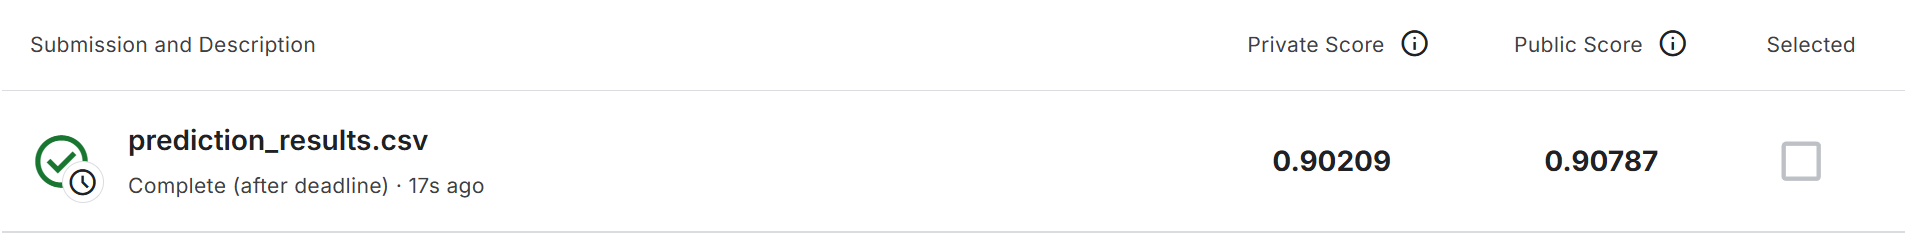

In [9]:
# 使用 GridSearchCV 寻找最优参数
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# 1. 划分特征 (X) 和目标变量 (y)
X = train_df_encoded.drop(columns=['NObeyesdad'])
y = train_df_encoded['NObeyesdad']

# 2. 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义基础模型
base_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    random_state=42
)

# 定义待搜索的参数网格（根据需要调整）
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='accuracy',  # 根据需要选择评价指标
    cv=5,                # 5折交叉验证
    verbose=1,
    n_jobs=-1            # 并行搜索
)

# 开始搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数和对应的得分
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}%".format(grid_search.best_score_ * 100))

# 使用最佳参数训练最终模型
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# 在验证集上评估
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy with Best Params: {val_accuracy * 100:.2f}%")

# 对测试集进行预测
X_test = test_df_encoded
y_test_pred = best_model.predict(X_test)
y_test_pred_original = label_encoder.inverse_transform(y_test_pred)

# 将预测结果整合进 DataFrame
prediction_df = pd.DataFrame()
prediction_df['id'] = test_df['id']
prediction_df['Predicted_NObeyesdad'] = y_test_pred_original

print(prediction_df.head())

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}
Best cross-validation score: 91.04%
Validation Accuracy with Best Params: 90.85%
      id Predicted_NObeyesdad
0  20758      Obesity_Type_II
1  20759   Overweight_Level_I
2  20760     Obesity_Type_III
3  20761       Obesity_Type_I
4  20762     Obesity_Type_III


使用XGBoost进行预测结果，并使用 GridSearchCV 寻找最优参数

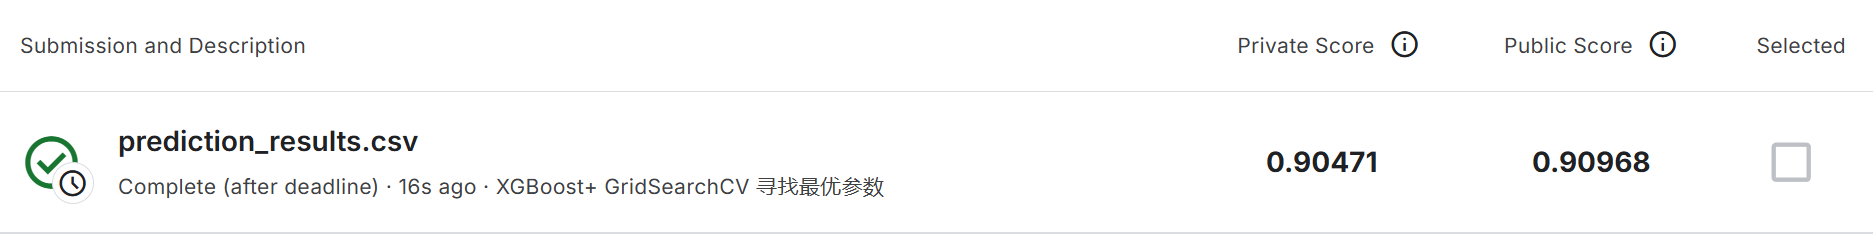

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import numpy as np

# 1. 划分特征 (X) 和目标变量 (y)
X = train_df_encoded.drop(columns=['NObeyesdad'])
y = train_df_encoded['NObeyesdad']

# 2. 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义参数搜索空间
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
}

def objective(params):
    # 转换为整型参数
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_weight'] = int(params['min_child_weight'])

    model = XGBClassifier(
        objective='multi:softmax',
        num_class=len(y.unique()),
        eval_metric='mlogloss',
        random_state=42,
        **params
    )

    # 5折交叉验证计算准确率
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    loss = -scores.mean()  # 因为hyperopt最小化loss，这里用负的准确率
    return {'loss': loss, 'status': STATUS_OK}

trials = Trials()

# 使用新的随机数生成器 default_rng
best = fmin(
    fn=objective, 
    space=space, 
    algo=tpe.suggest, 
    max_evals=50,
    trials=trials, 
    rstate=np.random.default_rng(42)  # 使用新API的生成器
)

print("Best hyperparameters found by hyperopt:")
print(best)

# 整理最佳参数类型
best['max_depth'] = int(best['max_depth'])
best['n_estimators'] = int(best['n_estimators'])
best['min_child_weight'] = int(best['min_child_weight'])

# 使用最佳参数训练最终模型
best_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    max_depth=best['max_depth'],
    learning_rate=best['learning_rate'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    n_estimators=best['n_estimators']
)

best_model.fit(X_train, y_train)

# 在验证集上评估模型
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy with Best Params: {val_accuracy * 100:.2f}%")

# 使用最终模型对测试集进行预测
X_test = test_df_encoded
y_test_pred = best_model.predict(X_test)
y_test_pred_original = label_encoder.inverse_transform(y_test_pred)

# 将预测结果整合进 DataFrame
prediction_df = pd.DataFrame()
prediction_df['id'] = test_df['id']
prediction_df['Predicted_NObeyesdad'] = y_test_pred_original

print(prediction_df.head())

100%|██████████| 50/50 [07:54<00:00,  9.50s/trial, best loss: -0.9102134973453555]
Best hyperparameters found by hyperopt:
{'colsample_bytree': np.float64(0.7702320596077517), 'learning_rate': np.float64(0.05947986161673085), 'max_depth': np.float64(5.0), 'min_child_weight': np.float64(10.0), 'n_estimators': np.float64(400.0), 'subsample': np.float64(0.7236617974934909)}


d:\code\Python\artificial intelligence course\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:34:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Accuracy with Best Params: 90.75%
      id Predicted_NObeyesdad
0  20758      Obesity_Type_II
1  20759   Overweight_Level_I
2  20760     Obesity_Type_III
3  20761       Obesity_Type_I
4  20762     Obesity_Type_III


使用XGBoost进行预测结果，并使用贝叶斯寻找最优参数

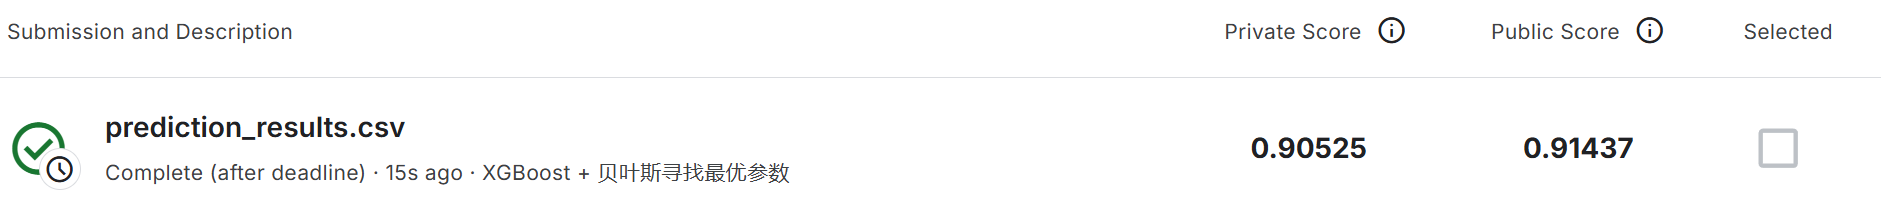

In [11]:
# 将预测结果写回文件中
prediction_df.to_csv('prediction_results.csv', index=False)

# 输出文件保存成功的提示
print("预测结果已成功保存到 prediction_results.csv")


预测结果已成功保存到 prediction_results.csv
